In [3]:
import Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate();

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [4]:
using JuMP
using DisjunctiveProgramming
using ToQUBO
using DisjunctiveToQUBO
using HiGHS
using DWave

In [5]:
include("squares.jl");

## Squares Model

$$
\begin{array}{rll}
\displaystyle \min_{x, y, Y} & x_1 - x_2 + y_1 + 5y_2 \\
            \textrm{s.t.} & Y_{1} \veebar Y_{2} \\
                ~ & \left[
                        \begin{array}{c}
                            Y_1 \\
                            -2 \leq x_{1}, x_{2} \leq -1 \\
                        \end{array}
                    \right] \bigvee
                    \left[
                        \begin{array}{c}
                            Y_2 \\
                            1 \leq x_{1}, x_{2} \leq 2 \\
                        \end{array}
                    \right] \\
                ~ & x_{i} \in [-2, 2] \\
                ~ & Y_{i} \in \{ \textrm{True}, \textrm{False} \}  & \forall i \\
                ~ & y_{i} \in \{ 0, 1 \}  & \forall i \\
                ~ & Y_{i} \iff y_{i} = 1  & \forall i \\
\end{array}
$$

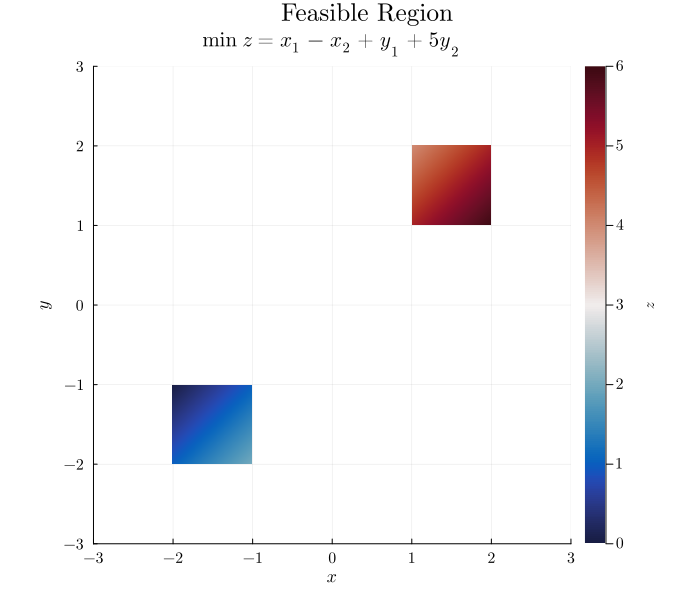

In [6]:
plot_square_feasible()

### Optimal Solution

In [7]:
x⃰, z⃰ = let model = solve_gdp_squares(HiGHS.Optimizer; method=BigM(3.0, false)) do m
        set_silent(m)
    end

    value.(model[:x]), objective_value(model)
end

([-2.0, -1.0], 0.0)

## Big-M Reformulation

In [8]:
bigm_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = BigM(3.0, false)
) do m
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(bigm_model)
solution_summary(bigm_model)
sampling_summary(bigm_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 34
  Encoding ………………… 10
  Slack ………………………… 24
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.2798573975044563

⋄ Coefficient Range
  Lower Bound ………… -734.0
  Upper Bound ………… 360.0

⋄ Constant Offset: 2235.0

⋄ Work counters
  Compiltaion Time (sec) : 5.779970367



⋄ Sampling Summary

⋄ Number of samples: 853

⋄ Best energy: 0.0

⋄ Time-to-target (sec): 464.487213681048



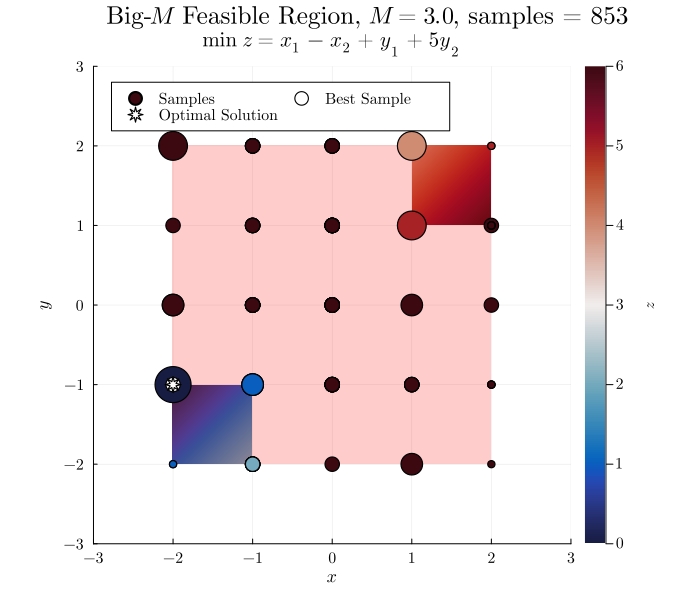

In [9]:
plot_square_bigm(bigm_model, x⃰, 3.0)

## Hull Reformulation

In [10]:
hull_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method=Hull()
) do m
    set_attribute(m, "num_reads",  5_000)
    # set_attribute(m, "num_sweeps", 5_000)

    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingBits(), 4)
    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingMethod(), ToQUBO.Encoding.Unary())
    
    # set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
    # set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
end

compilation_summary(hull_model)
solution_summary(hull_model)
sampling_summary(hull_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 82
  Encoding ………………… 26
  Slack ………………………… 56
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.15206263173742848

⋄ Coefficient Range
  Lower Bound ………… -225.0
  Upper Bound ………… 740.0

⋄ Constant Offset: 1095.0

⋄ Work counters
  Compiltaion Time (sec) : 0.092537796

⋄ Sampling Summary

⋄ Number of samples: 5000

⋄ Best energy: 1.0

⋄ Time-to-target (sec): -Inf



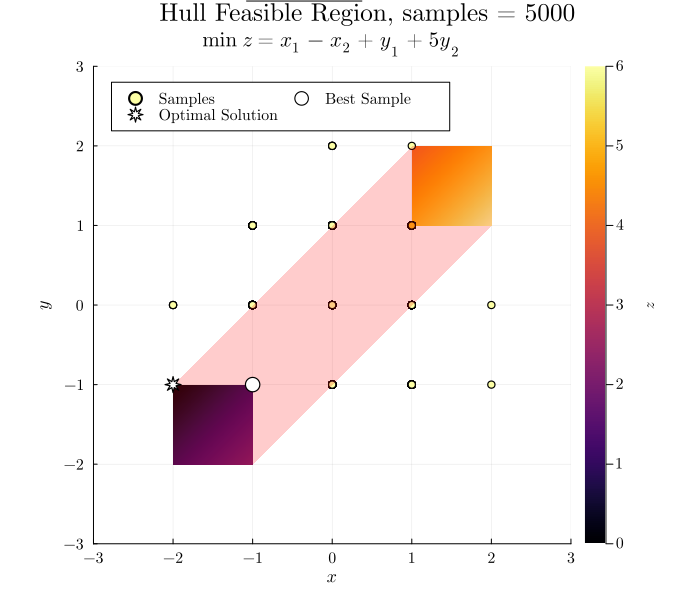

In [11]:
plot_square_hull(hull_model, x⃰)

## Indicator Reformulation

In [12]:
ind_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method=Indicator()
) do m
    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingBits(), 4)
    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(ind_model)
solution_summary(ind_model)
sampling_summary(ind_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 158
  Encoding ………………… 10
  Slack ………………………… 20
  Quadratization … 128

⋄ Density
  Linear ……………………… 0.8734177215189873
  Quadratic ……………… 0.03555591389180037

⋄ Coefficient Range
  Lower Bound ………… -180.0
  Upper Bound ………… 740.0

⋄ Constant Offset: 15.0

⋄ Work counters
  Compiltaion Time (sec) : 1.464641319

⋄ Sampling Summary

⋄ Number of samples: 1000

⋄ Best energy: 0.0

⋄ Time-to-target (sec): 25531.398211428685



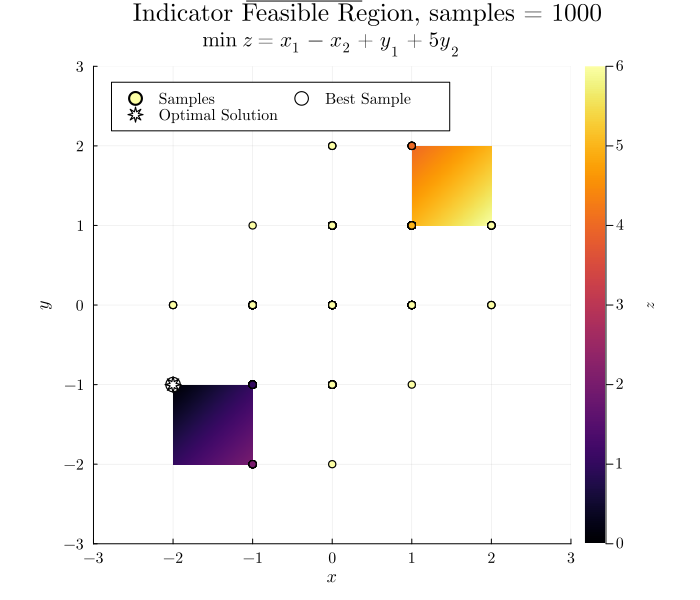

In [13]:
plot_square_indicator(ind_model, x⃰)

## Indicator-Interval Reformulation

In [14]:
struct DisjunctEncoding{T} <: ToQUBO.Encoding.VariableEncodingMethod end

DisjunctEncoding() = DisjunctEncoding{Float64}()

ToQUBO.PBO.varshow(v::ToQUBO.VI) = ToQUBO.PBO.varshow(v.value)

In [115]:
function solve_indint_squares()
    model = Model(() -> ToQUBO.Optimizer(DWave.Neal.Optimizer))

    @variable(model, y[1:2], Bin)
    @variable(model, x[1:2])

    @objective(model, Min, x[1] - x[2] + y[1] + 5y[2])
    @constraint(model, exactly1, sum(y) == 1)

    let virtual_model = unsafe_backend(model)
        virtual_model.compiler_settings[:setup_callback] = (m::ToQUBO.Optimizer) -> begin
            n = 4  # number of bits
            e = ToQUBO.Encoding.Unary()
            S = [(-2.0, -1.0), (1.0, 2.0)]  # intervals
            W = Vector{ToQUBO.VI}(undef, 2) # Disjunction Variables

            for j = 1:2 # y indices
                W[j] = only(ToQUBO.Encoding.encode!(m, y[j].index, ToQUBO.Encoding.Mirror()).y)
            end

            for i = 1:2 # variables
                Z = ToQUBO.VI[]
                Ξ = ToQUBO.PBO.PBF{ToQUBO.VI,Float64}()
                Χ = nothing
                
                for j = 1:2 # disjuncts
                    # Manual encoding
                    z, ξ, χ = ToQUBO.Encoding.encode(e, S[j], n) do (nv::Union{Integer,Nothing} = nothing)
                        if isnothing(nv)
                            return MOI.add_variable(m.target_model)
                        else
                            return MOI.add_variables(m.target_model, nv)
                        end
                    end
                    
                    append!(Z, z)

                    Ξ += ToQUBO.PBO.PBF{ToQUBO.VI,Float64}(W[j]) * ξ

                    Χ = isnothing(χ) ? Χ : (isnothing(Χ) ? χ : (Χ += χ))
                end

                v = ToQUBO.Virtual.Variable{Float64}(
                    DisjunctEncoding(), # new encoding method
                    x[i].index,
                    Z,
                    Ξ,
                    Χ,
                )

                ToQUBO.Encoding.encode!(m, v)
            end
        end
    end

    set_attribute(model, ToQUBO.Attributes.Quadratize(), true)

    optimize!(model)

    return model
end

indint_model  = solve_indint_squares()
virtual_model = unsafe_backend(indint_model)

compilation_summary(indint_model)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 18
  Encoding ………………… 18
  Slack ………………………… 0
  Quadratization … 0

⋄ Density
  Linear ……………………… 0.1111111111111111
  Quadratic ……………… 0.1111111111111111

⋄ Coefficient Range
  Lower Bound ………… -10.0
  Upper Bound ………… 22.0

⋄ Constant Offset: 11.0

⋄ Work counters
  Compiltaion Time (sec) : 0.136694482



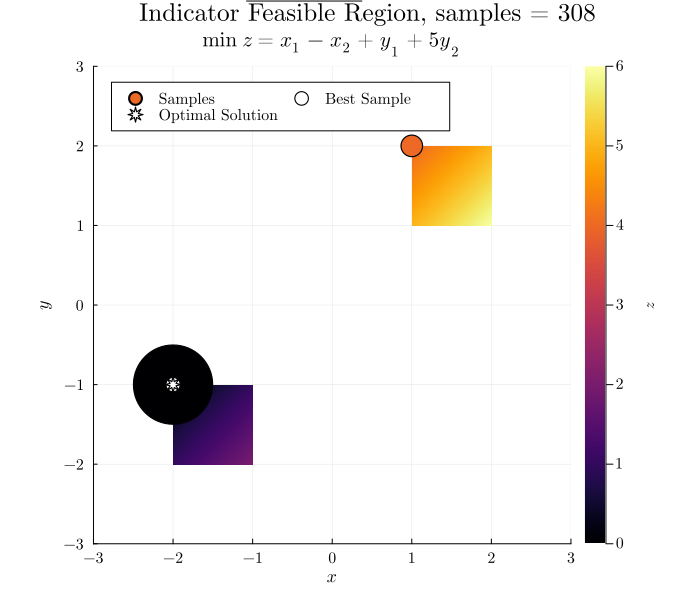

In [116]:
plot_square_indicator(indint_model, x⃰)